In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [ ]:
from scipy.integrate import cumulative_trapezoid as cumtrapz

def compute_delta_J_cumulative(r, delta_J, r_max=1.0):
    r = np.asarray(r, dtype=float)
    dJ = np.asarray(delta_J, dtype=float)
    mask = np.isfinite(r) & np.isfinite(dJ) & (r > 0) & (r <= r_max)
    if mask.sum() < 3:
        return None, None
    r, dJ = r[mask], dJ[mask]
    if not np.all(np.diff(r) > 0):
        idx = np.argsort(r)
        r, dJ = r[idx], dJ[idx]
    J_cum = cumtrapz(dJ, r, initial=0.0)
    return r, J_cum

def plot_mean_cumulative_jeans_deviation_normalized(
    base_dir, suite_names, jeans_dir_name="jeans_deviation",
    r_max=1.0, n_grid=128, use_median=False
):
    plt.figure(figsize=(7,6), dpi=500)

    for suite in suite_names:
        jdir = os.path.join(base_dir, "output", suite, jeans_dir_name)
        files = sorted([f for f in os.listdir(jdir) if f.endswith(".csv")])

        per_halo_r, per_halo_Jn = [], []

        for f in files:
            df = pd.read_csv(os.path.join(jdir, f))
            r  = pd.to_numeric(df["r_scaled"], errors="coerce").values
            dJ = pd.to_numeric(df["delta_J"],  errors="coerce").values

            r_cut, J_cum = compute_delta_J_cumulative(r, dJ, r_max=r_max)
            if r_cut is None:
                continue
            J_end = J_cum[-1]
            if not np.isfinite(J_end) or J_end == 0:
                continue
            J_norm = J_cum / J_end  # normalize by ΔJ_tot(<r_max)
            per_halo_r.append(r_cut)
            per_halo_Jn.append(J_norm)

        if len(per_halo_r) == 0:
            continue

        # Common log-radius grid (intersection)
        rmin = max(r_.min() for r_ in per_halo_r)
        rmax = min(r_.max() for r_ in per_halo_r)
        if not (np.isfinite(rmin) and np.isfinite(rmax) and rmax > rmin):
            continue
        r_grid = np.logspace(np.log10(rmin), np.log10(rmax), n_grid)

        # Interpolate normalized curves to common grid
        stack = []
        for r_, Jn_ in zip(per_halo_r, per_halo_Jn):
            y = np.full_like(r_grid, np.nan, dtype=float)
            inside = (r_grid >= r_.min()) & (r_grid <= r_.max())
            if inside.any():
                y[inside] = np.interp(np.log10(r_grid[inside]), np.log10(r_), Jn_)
            stack.append(y)
        Y = np.vstack(stack)

        # Center and spread
        if use_median:
            center = np.nanmedian(Y, axis=0)
            spread = 1.4826 * np.nanmedian(np.abs(Y - center), axis=0)
        else:
            center = np.nanmean(Y, axis=0)
            spread = np.nanstd(Y, axis=0)

        plt.plot(r_grid, center, lw=2.0, color=sim_colors[suite], label=suite)
        #plt.fill_between(r_grid, center - spread, center + spread, color=sim_colors[suite], alpha=0.25)

    plt.xscale("log")
    plt.xlabel(r"$r / R_{\rm vir}$", fontsize=14)
    plt.ylabel(r"$\delta_J(<r)/\delta_J(<R_{\mathrm{vir}})$", fontsize=14)
    plt.grid(True, ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mean_cumulative_jeans_deviation_normalized(base_dir, suite_names, r_max=1.0,)

In [ ]:
from scipy.integrate import cumulative_trapezoid as cumtrapz

def compute_delta_J_cumulative(r, delta_J, r_max=1.0):
    """Return r_cut, J_cum within r <= r_max (cumulative trapezoid)."""
    r = np.asarray(r, dtype=float)
    dJ = np.asarray(delta_J, dtype=float)
    mask = np.isfinite(r) & np.isfinite(dJ) & (r > 0) & (r <= r_max)
    if mask.sum() < 3:
        return None, None
    r, dJ = r[mask], dJ[mask]
    if not np.all(np.diff(r) > 0):
        idx = np.argsort(r)
        r, dJ = r[idx], dJ[idx]
    J_cum = cumtrapz(dJ, r, initial=0.0)
    return r, J_cum

def plot_mean_cumulative_jeans_deviation(base_dir, suite_names, jeans_dir_name="jeans_deviation", r_max=1.0, n_grid=128):
    plt.figure(figsize=(7,6), dpi=500)

    for suite in suite_names:
        jdir = os.path.join(base_dir, "output", suite, jeans_dir_name)
        files = sorted([f for f in os.listdir(jdir) if f.endswith(".csv")])

        per_halo_r = []
        per_halo_J = []

        for f in files:
            df = pd.read_csv(os.path.join(jdir, f))
            r = pd.to_numeric(df["r_scaled"], errors="coerce").values
            dJ = pd.to_numeric(df["delta_J"], errors="coerce").values

            r_cut, J_cum = compute_delta_J_cumulative(r, dJ, r_max=r_max)
            if r_cut is not None:
                per_halo_r.append(r_cut)
                per_halo_J.append(J_cum)

        if len(per_halo_r) == 0:
            continue

        # Common log radius grid
        rmin = max(r_.min() for r_ in per_halo_r)
        rmax = min(r_.max() for r_ in per_halo_r)
        r_grid = np.logspace(np.log10(rmin), np.log10(rmax), n_grid)

        # Interpolate all halos onto grid
        stack = []
        for r_, J_ in zip(per_halo_r, per_halo_J):
            y_interp = np.full_like(r_grid, np.nan)
            inside = (r_grid >= r_.min()) & (r_grid <= r_.max())
            y_interp[inside] = np.interp(np.log10(r_grid[inside]), np.log10(r_), J_)
            stack.append(y_interp)
        stack = np.array(stack)

        # Mean ± 1σ
        mean_J = np.nanmean(stack, axis=0)
        std_J  = np.nanstd(stack, axis=0)

        plt.plot(r_grid, mean_J, lw=1.5, color=sim_colors[suite], label=suite)
        plt.fill_between(r_grid, mean_J-std_J, mean_J+std_J, color=sim_colors[suite], alpha=0.25)

    plt.xscale("log")
    plt.xlabel(r"$r / R_{\rm vir}$", fontsize=14)
    plt.ylabel(r"$\delta_J(<r)$", fontsize=14)
    plt.grid(True, ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mean_cumulative_jeans_deviation(base_dir, suite_names, jeans_dir_name="jeans_deviation", r_max=1.0)

In [ ]:
G = 1 
from scipy.integrate import cumulative_trapezoid as cumtrapz

def sci_notation_latex(x, precision=2):

    fmt = f"{x:.{precision}e}"
    base, exponent = fmt.split("e")
    return rf"{base} \times 10^{{{int(exponent)}}}"

def compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_tot, r_max=1.0):
    r = np.asarray(r); rho = np.asarray(rho)
    m_enc = np.asarray(m_enc); sigma_tot = np.asarray(sigma_tot)

    # mask: finite, r>0, within r_max
    mask = (np.isfinite(r) & np.isfinite(rho) &
            np.isfinite(m_enc) & np.isfinite(sigma_tot) &
            (r > 0) & (r <= r_max))

    r, rho, m_enc, sigma_tot = r[mask], rho[mask], m_enc[mask], sigma_tot[mask]

    # shell integrands (dV = 4π r^2 dr)
    vol_shell = 4.0 * np.pi * r**2
    K_shell = 0.5 * rho * (sigma_tot**2) * vol_shell
    U_shell = -G * m_enc * rho / r * vol_shell

    # cumulative integrals
    K_cum = cumtrapz(K_shell, r, initial=0.0)
    U_cum = cumtrapz(U_shell, r, initial=0.0)

    # last valid point within r_max
    if not np.isfinite(U_cum[-1]) or U_cum[-1] == 0 or K_cum[-1] <= 0:
        return np.nan

    return 2.0 * K_cum[-1] / abs(U_cum[-1])

def compare_normalized_jeans_deviation_vs_virial_ratio():

    delta_J_list = []
    eta_list     = []
    mass_list    = []

    # 1) Gather raw δJ, η, and M_vir for all halos
    for suite in suite_names:
        density_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        mass_dir    = os.path.join(base_dir, "output", suite, "mass_profiles")
        jeans_path  = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path   = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        # load δJ_tot per halo
        df_jeans = pd.read_csv(jeans_path)
        jeans_dict = dict(zip(df_jeans["halo_id"],
                              pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')))
        # load M_vir per halo
        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"],
                             pd.to_numeric(df_mass["mvir"], errors='coerce')))

        # loop through each halo’s density file to compute η
        for fname in sorted(os.listdir(density_dir)):
            if not fname.endswith(".csv"):
                continue
            try:
                halo_id = int(fname.split("_")[1])
                if halo_id not in jeans_dict or halo_id not in mass_dict:
                    continue

                # read profiles
                df_rho = pd.read_csv(os.path.join(density_dir, fname))
                df_vel = pd.read_csv(os.path.join(velocity_dir, fname))
                df_menc= pd.read_csv(os.path.join(mass_dir, fname))

                r      = pd.to_numeric(df_rho["r_scaled"], errors='coerce').values
                rho    = pd.to_numeric(df_rho["rho_scaled"], errors='coerce').values
                m_enc  = pd.to_numeric(df_menc["m_scaled"], errors='coerce').values
                sigma_tot = pd.to_numeric(df_vel["sigma_total_scaled"], errors='coerce').values

                # compute virial ratio η = 2K/|U|
                eta = compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_tot, r_max=1.0)
                delta_J = jeans_dict[halo_id]
                mvir    = mass_dict[halo_id]

                if np.isfinite(eta) and np.isfinite(delta_J) and np.isfinite(mvir):
                    eta_list.append(eta)
                    delta_J_list.append(delta_J)
                    mass_list.append(mvir)

            except Exception as e:
                print(f"[Warning] failed to process {suite} halo {fname}: {e}")

    # convert to arrays
    delta_J_arr = np.array(delta_J_list)
    eta_arr     = np.array(eta_list)
    logM_arr    = np.log10(np.array(mass_list))

    # check we have enough halos
    if delta_J_arr.size < 5:
        print("[Warning] Too few halos for meaningful correlation.")
        return

    # 2) normalize δJ by median and std
    med_J = np.median(delta_J_arr)
    std_J = np.std(delta_J_arr)
    if std_J <= 0:
        print("[Warning] zero variance in Jeans deviation; cannot normalize.")
        return
    delta_J_norm = (delta_J_arr - med_J) / std_J

    # 3) compute Spearman correlation
    rho_s, p_s = spearmanr(delta_J_norm, eta_arr)

    # 4) plotting
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(7,6), dpi=500)
    sc = plt.scatter(
        delta_J_norm, eta_arr,
        c=logM_arr, cmap="viridis", s=25, alpha=0.8, edgecolors="none"
    )
    plt.axhline(1.0, color="gray", linestyle="--")
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)

    plt.xlabel(r"$\delta_{J,\mathrm{norm}} \equiv (\delta_J-\delta_{J,\mathrm{med}}) / \sigma_{\delta_J}$", fontsize=18)
    plt.ylabel(r"$\eta = \frac{2K}{|U|}$", fontsize=18)
    plt.grid(True, linestyle=":")

    txt = rf"$\rho = {rho_s:.3f}$" + "\n" + r"$p < 10^{-10}$"
    plt.text(0.8, 0.15, txt,
             transform=plt.gca().transAxes,
             ha='center', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=1),
             fontsize=15)
    plt.savefig(os.path.join(out_dir, f"delta_jeans_vs_eta.pdf"))
    plt.tight_layout()
    plt.show()

compare_normalized_jeans_deviation_vs_virial_ratio()


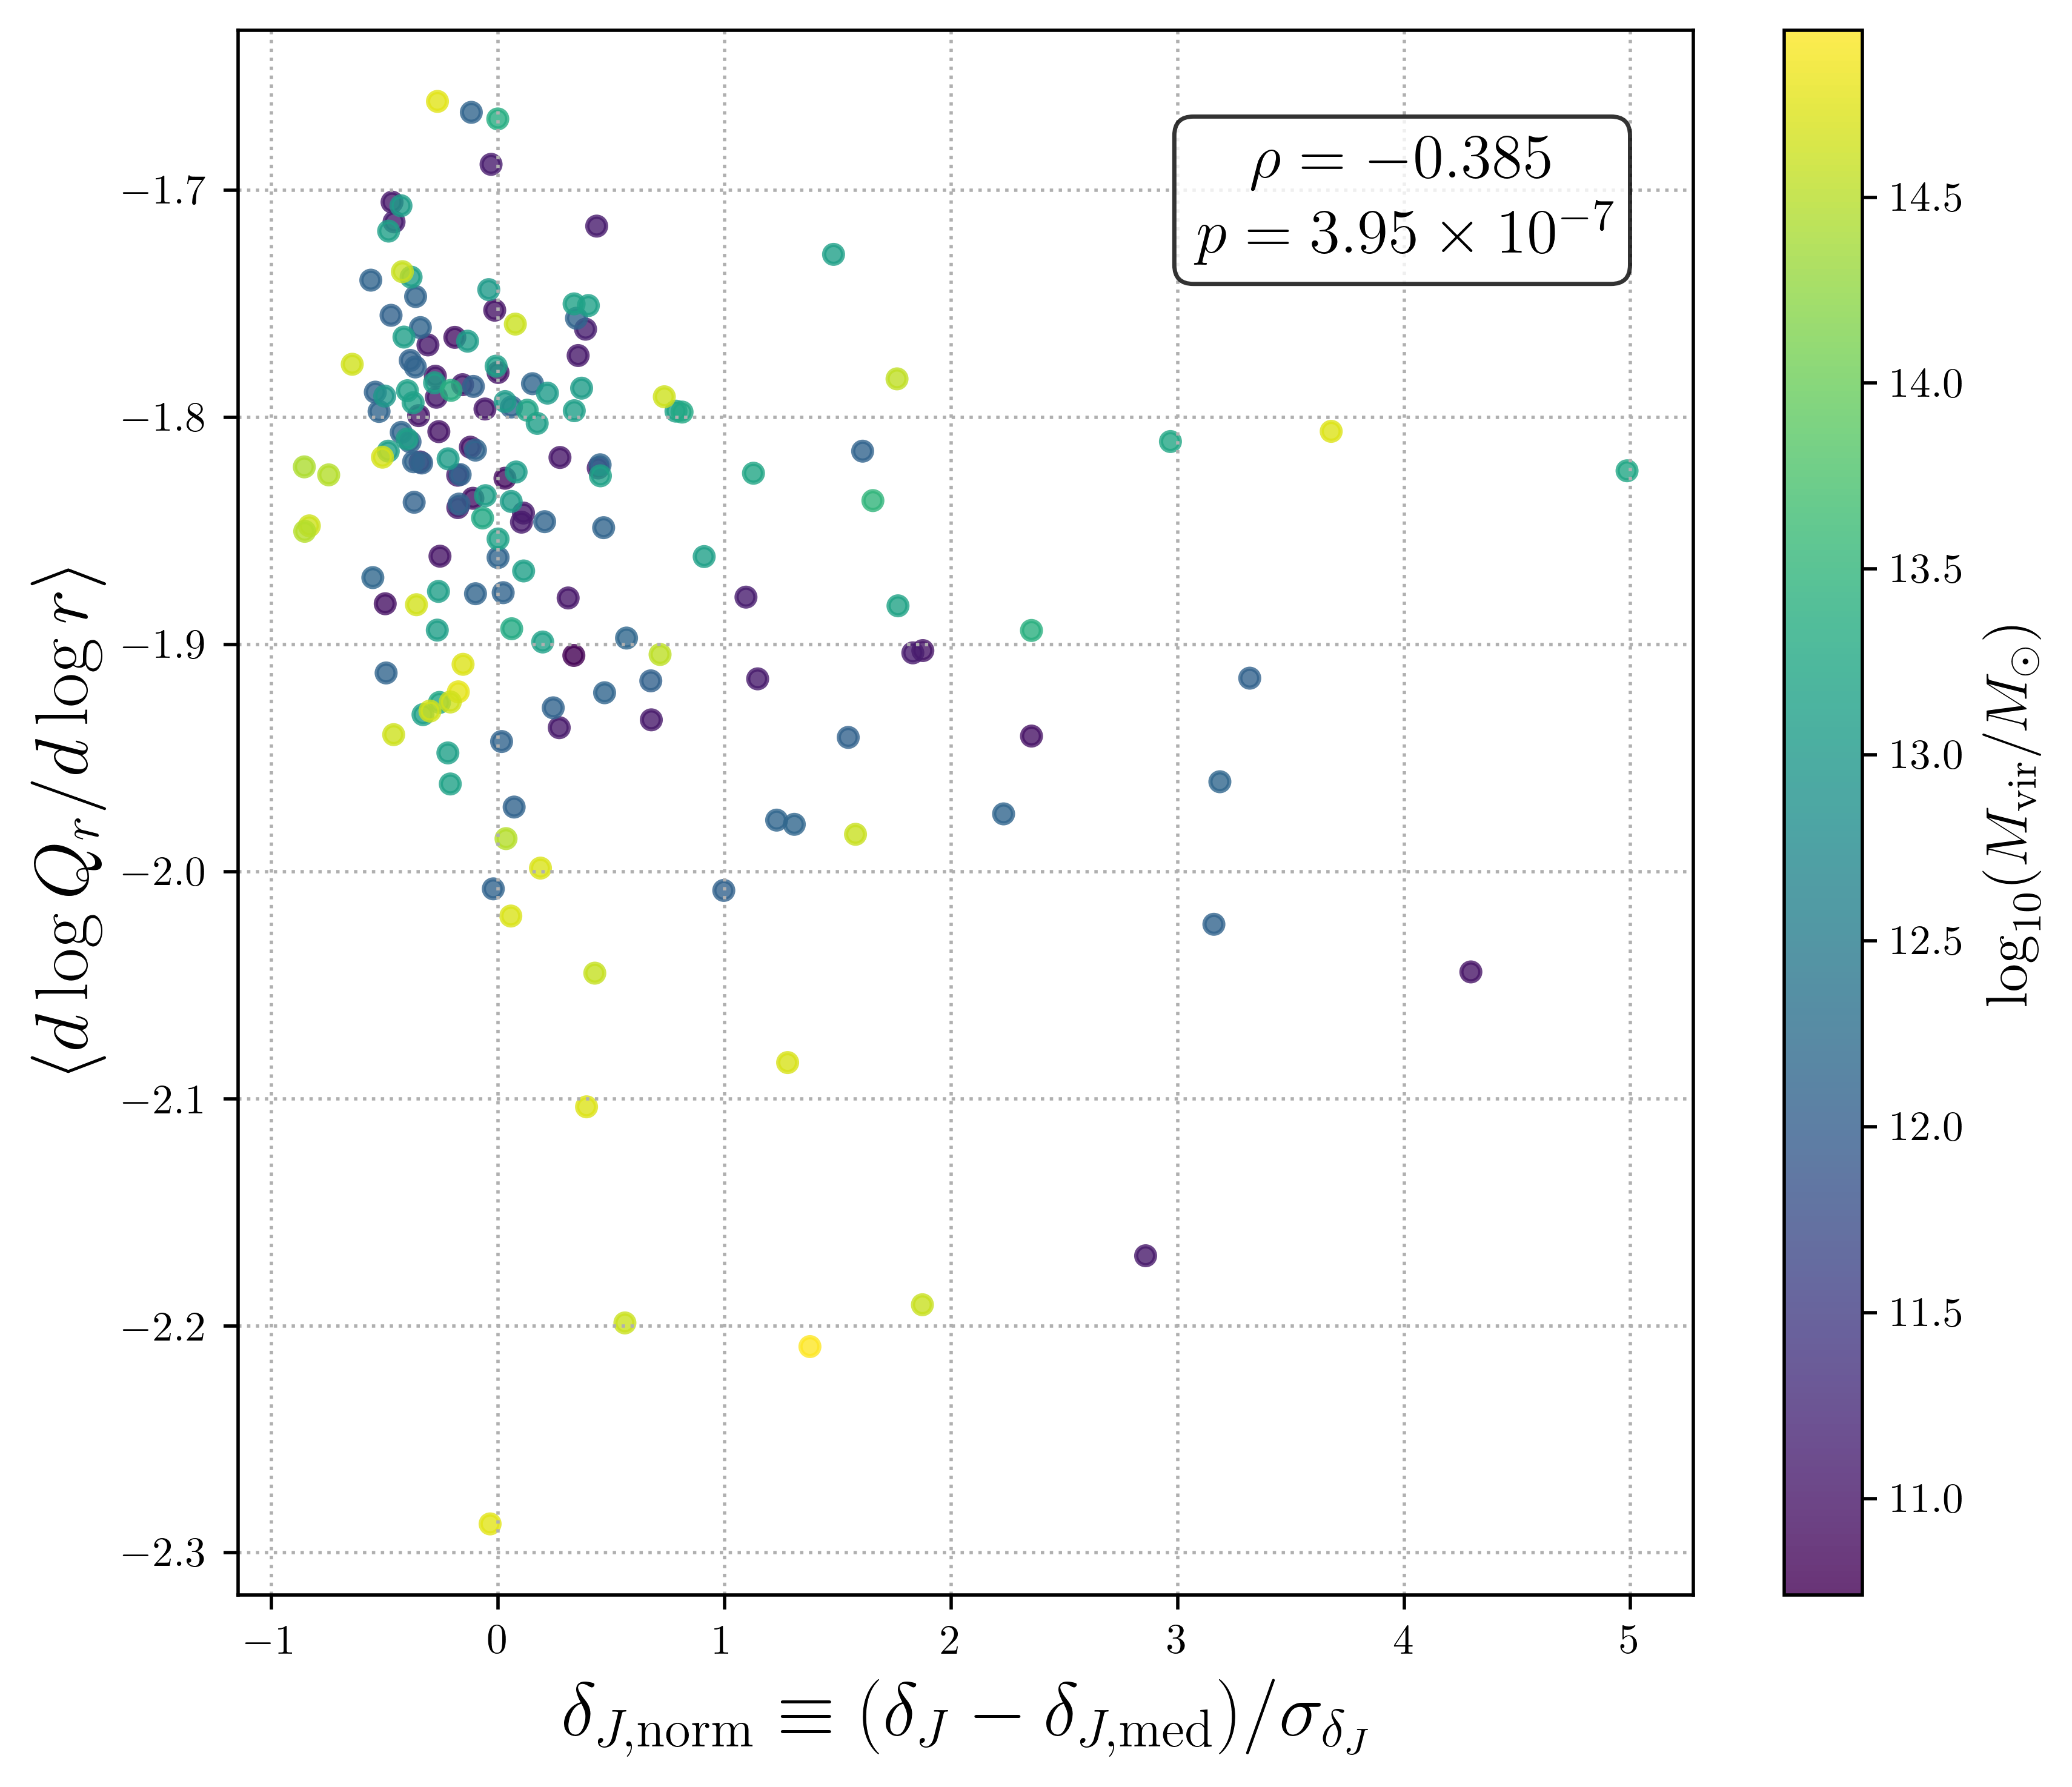

In [23]:
def const_model(r, a):
    """A one-parameter constant model: y(r) = a."""
    return a * np.ones_like(r)

def plot_bestfit_ppsd_slope_vs_jeans_deviation_norm(r_fit_range= (0.01, 1.0)): 
    slope_vals, jeans_norm_vals, log_mass_vals = [], [], []

    for suite in suite_names:
        slope_dir  = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        jeans_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path  = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_jeans = pd.read_csv(jeans_path)
        dJ       = pd.to_numeric(df_jeans["delta_J_tot"], errors="coerce")
        median_j, std_j = np.nanmedian(dJ), np.nanstd(dJ)
        jeans_norm = {hid: (dj - median_j) / std_j for hid, dj in zip(df_jeans["halo_id"], dJ)}

        df_mass  = pd.read_csv(mass_path)
        mass_map = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors="coerce")))

        for fname in sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv")):
            try:
                hid = int(fname.split("_")[1]) 
            except Exception:
                continue

            try:
                df = pd.read_csv(os.path.join(slope_dir, fname))
                r  = pd.to_numeric(df["r_scaled"], errors="coerce").to_numpy(float)
                s  = pd.to_numeric(df["slope_Q_r"], errors="coerce").to_numpy(float)

                mask = (r >= r_fit_range[0]) & (r <= r_fit_range[1]) & np.isfinite(s)
                if mask.sum() < 5:
                    continue  # not enough points for a stable fit

                r_fit, s_fit = r[mask], s[mask]

                try:
                    popt, _ = curve_fit(const_model, r_fit, s_fit, p0=[np.median(s_fit)])
                    best_slope = popt[0]
                except Exception:
                    best_slope = np.median(s_fit)

                dj_norm = jeans_norm.get(hid, np.nan)
                mvir    = mass_map.get(hid,  np.nan)

                if np.isfinite(best_slope) and np.isfinite(dj_norm):
                    slope_vals.append(best_slope)
                    jeans_norm_vals.append(dj_norm)
                    log_mass_vals.append(np.log10(mvir) if np.isfinite(mvir) else np.nan)

            except Exception as err:
                print(f"[Warning] {suite}/{fname}: {err}")

    slope_vals, jeans_norm_vals, log_mass_vals = map(np.asarray, (slope_vals, jeans_norm_vals, log_mass_vals))

    rho, pval = spearmanr(jeans_norm_vals, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    plt.rcParams['text.usetex'] = True
    sc = plt.scatter(jeans_norm_vals, slope_vals, c=log_mass_vals,
                     cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)
    plt.xlabel(r"$\delta_{J,\mathrm{norm}} \equiv (\delta_J-\delta_{J,\mathrm{med}}) / \sigma_{\delta_J}$", fontsize=18)
    plt.ylabel(r"$\langle d\log Q_r / d\log r\rangle$", fontsize=18)
    txt = rf"$\rho = {rho:.3f}$" + "\n" + rf"$p = {sci_notation_latex(pval)}$"
    plt.gca().text(0.8, 0.85, txt, transform=plt.gca().transAxes,
                   ha="center", va="bottom",
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),fontsize=15)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"ppsd_slope_vs_delta_jeans.pdf"))
    plt.show()

suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"]
plot_bestfit_ppsd_slope_vs_jeans_deviation_norm(r_fit_range=(5e-3, 1.2))


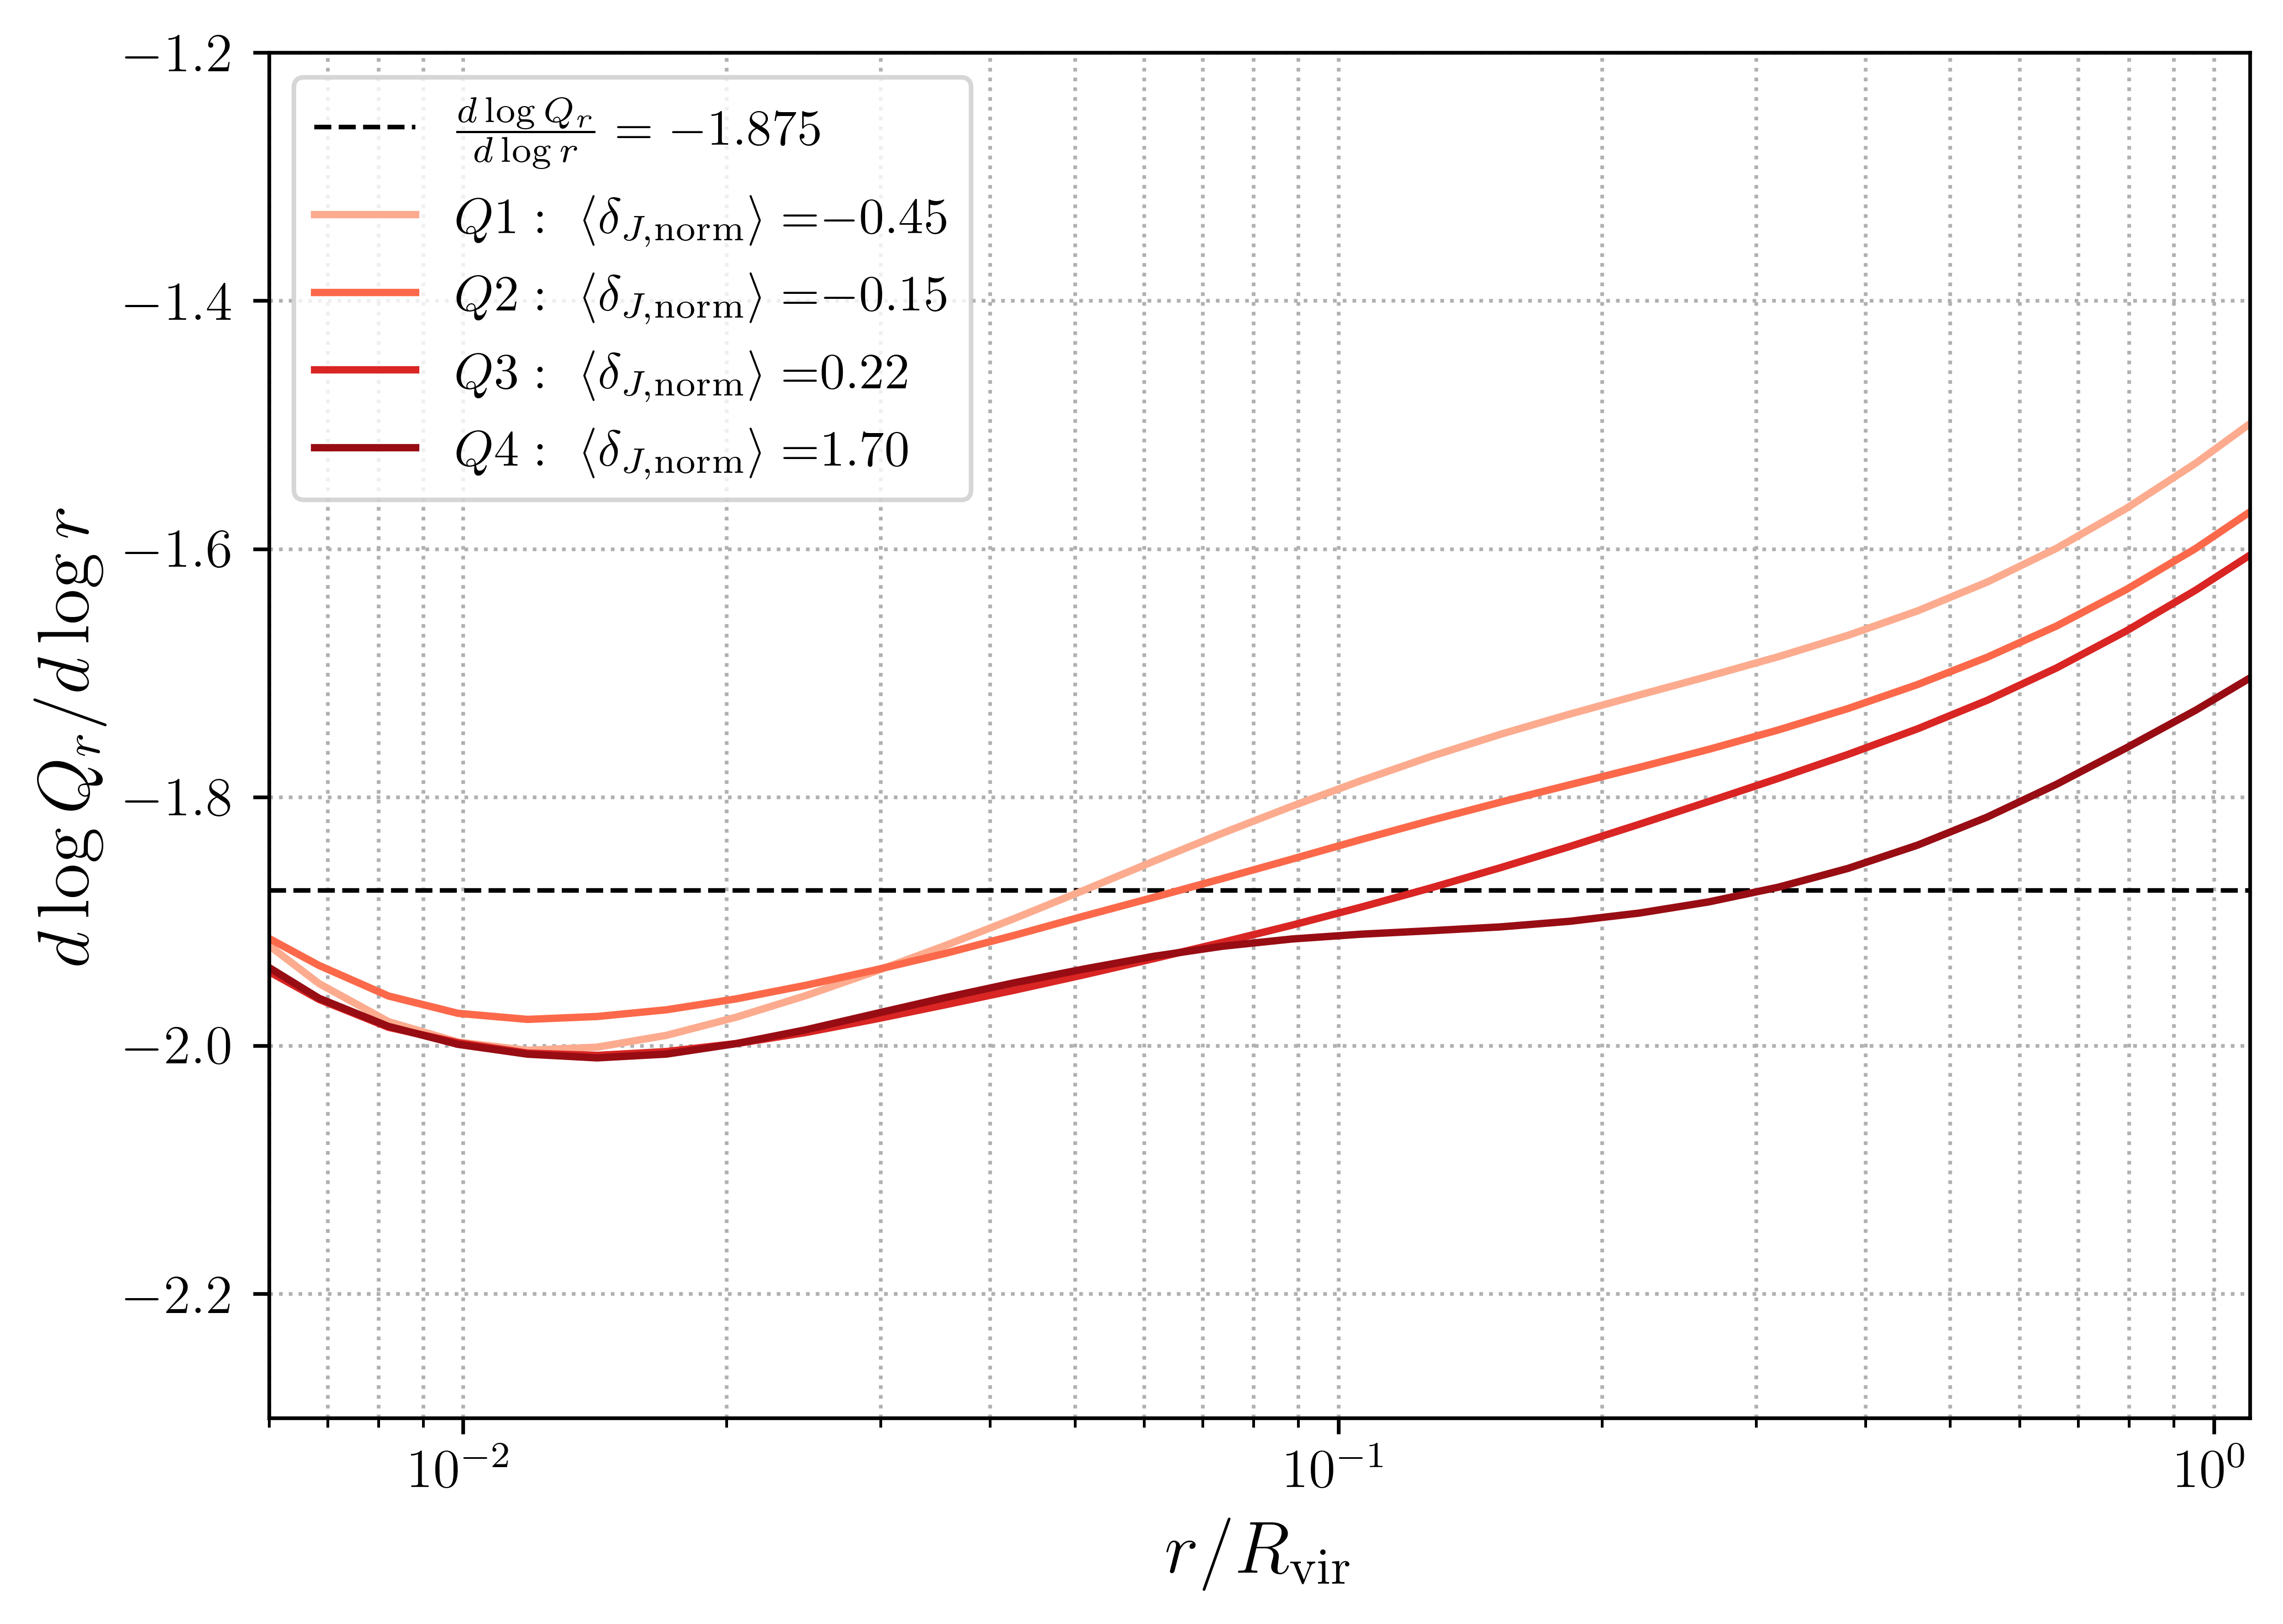

In [ ]:
def plot_ppsd_slope_split_by_jeans_norm_quartiles_vs_r_per_suite():
    import numpy as np
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    # Aggregators across all suites
    jd_quart_slopes = {0: [], 1: [], 2: [], 3: []}
    jd_quart_vals   = {0: [], 1: [], 2: [], 3: []}  # store per-halo jd_norm to report mean in label

    r_ref = None
    n_r_ref = None

    for suite in suite_names:
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        if not os.path.isdir(dir_r):
            continue

        # Read per-halo total Jeans deviation for this suite
        jd_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        if not os.path.isfile(jd_path):
            continue

        dfj = pd.read_csv(jd_path)
        # Expect columns: "halo_id", "delta_J_tot"
        dfj["halo_id_int"] = pd.to_numeric(dfj.get("halo_id"), errors="coerce").astype("Int64")
        dfj["delta_J_tot"] = pd.to_numeric(dfj.get("delta_J_tot"), errors="coerce")

        vals = dfj["delta_J_tot"].to_numpy(dtype=float)
        vals = vals[np.isfinite(vals)]

        # Suite-level normalization of total Jeans deviation: (x - median)/std
        if vals.size < 4 or np.nanstd(vals) == 0:
            jd_quart_edges = None
        else:
            med = np.nanmedian(vals)
            std = np.nanstd(vals)
            dfj["jd_norm"] = (dfj["delta_J_tot"] - med) / std
            jd_quart_edges = np.nanpercentile(dfj["jd_norm"], [25, 50, 75])

        # Build lookup map: halo_id -> jd_norm
        jd_norm_map = {}
        if jd_quart_edges is not None and "jd_norm" in dfj.columns:
            for hid, jn in zip(dfj["halo_id_int"], dfj["jd_norm"]):
                if pd.notna(hid) and np.isfinite(jn):
                    jd_norm_map[int(hid)] = float(jn)

        # Helper: assign quartile index
        def assign_quartile(val, edges):
            q1, q2, q3 = edges
            if val <= q1:
                return 0
            elif val <= q2:
                return 1
            elif val <= q3:
                return 2
            else:
                return 3

        # Iterate slope curves for this suite
        for fn in sorted(os.listdir(dir_r)):
            if not fn.endswith(".csv"):
                continue
            try:
                # parse halo index from filename like "halo_012_profile.csv"
                idx = int(fn.split("_")[1])
            except Exception:
                continue

            if (jd_quart_edges is None) or (idx not in jd_norm_map):
                continue

            df = pd.read_csv(os.path.join(dir_r, fn))
            sr = pd.to_numeric(df["slope_Q_r"], errors="coerce").to_numpy()

            if r_ref is None:
                r_ref = pd.to_numeric(df["r_scaled"], errors="coerce").to_numpy()
                n_r_ref = r_ref.size
            else:
                # Skip curves with mismatched radial grid length
                if sr.size != n_r_ref:
                    continue

            jn = jd_norm_map[idx]
            q_idx = assign_quartile(jn, jd_quart_edges)
            jd_quart_slopes[q_idx].append(sr)
            jd_quart_vals[q_idx].append(jn)

    if r_ref is None:
        print("[Warning] No valid slope data found for Jeans-deviation quartiles.")
        return

    # ---- Plot Q1 & Q4 only----
    plt.rcParams["text.usetex"] = True
    fig, ax = plt.subplots(figsize=(7, 5), dpi=600)

    ax.set_xscale("log")
    ax.grid(which="both", linestyle=":")
    ax.axhline(-1.875, ls="--", color="black", lw=1, label=r"$\frac{d\log Q_r}{d\log r}=-1.875$")
    ax.set_xlim(6e-3, 1.1)
    ax.set_ylim(-2.3, -1.2)
    ax.set_xlabel(r"$r / R_{\rm vir}$", fontsize=16)
    ax.set_ylabel(r"$d\log Q_r / d\log r$", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)

    cmap = plt.cm.Reds
    labels = ["Q1", "Q2", "Q3", "Q4"]
    colors = [cmap(0.3), cmap(0.5), cmap(0.7), cmap(0.9)]  

    for i, q in enumerate([0, 1, 2, 3]):  
        Ys = jd_quart_slopes[q]
        vs = jd_quart_vals[q]
        if len(Ys) == 0:
            ax.plot([], [], label=f"{labels[i]} (N=0)")
            continue

        Y = np.vstack(Ys)
        mu = np.nanmean(Y, axis=0)
        sd = np.nanstd(Y, axis=0)
        vmean = float(np.nanmean(vs)) if len(vs) else np.nan

        #ax.fill_between(r_ref, mu - sd, mu + sd, alpha=0.25, color=colors[i])
        ax.plot(
            r_ref, mu, lw=1.6, color=colors[i],
            label=r"$" + labels[i] + 
                r":\ \langle \delta_{J,\mathrm{norm}} \rangle = $" + rf"${vmean:.2f}$"
        )

    ax.legend(loc="upper left", fontsize=11)
    plt.tight_layout()
    out_path = os.path.join(out_dir, "ppsd_slope_r_split_jeans_norm_quartiles.pdf")
    plt.savefig(out_path)
    plt.show()
    plt.close(fig)

plot_ppsd_slope_split_by_jeans_norm_quartiles_vs_r_per_suite()

In [ ]:
def quantify_jeans_vs_cgamma(x_var="cvir"):
    x_vals, delta_j_vals, mass_vals = [], [], []

    for suite in suite_names:
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")
        jeans_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        df_mass = pd.read_csv(mass_path)
        df_jeans = pd.read_csv(jeans_path)

        # Create lookup dictionaries
        cvir_dict = dict(zip(df_cvir["halo_id"], pd.to_numeric(df_cvir["cvir"], errors='coerce')))
        gamma_dict = dict(zip(df_gamma["halo_index"], pd.to_numeric(df_gamma["gamma"], errors='coerce')))
        mass_dict = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))
        delta_j_dict = dict(zip(df_jeans["halo_id"], pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')))

        # Normalized variables (computed within each suite)
        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med, c_std = np.nanmedian(c_vals), np.nanstd(c_vals)
            x_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            vals = df_gamma["gamma"].values
            valid_mask = (vals > 0) & np.isfinite(vals)
            log_vals = np.log10(vals[valid_mask])
            g_med, g_std = np.nanmedian(log_vals), np.nanstd(log_vals)
            x_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - g_med) / g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        # Loop over halos
        for halo_id in delta_j_dict:
            delta_j = delta_j_dict.get(halo_id)
            mass = mass_dict.get(halo_id, np.nan)

            if x_var == "cvir":
                x = cvir_dict.get(halo_id)
            elif x_var == "gamma":
                x = gamma_dict.get(halo_id)
                x = np.log10(x) if x is not None and x > 0 else np.nan
            elif x_var in ["delta_c_norm", "delta_gamma_norm"]:
                x = x_dict.get(halo_id)
            else:
                continue

            x = pd.to_numeric(x, errors='coerce')
            delta_j = pd.to_numeric(delta_j, errors='coerce')
            if np.isfinite(x) and np.isfinite(delta_j):
                x_vals.append(x)
                delta_j_vals.append(delta_j)
                mass_vals.append(mass)

    x_vals = np.array(x_vals)
    delta_j_vals = np.array(delta_j_vals)
    mass_vals = np.array(mass_vals)

    if len(x_vals) < 2:
        print("[Warning] Not enough valid data.")
        return

    log_mass = np.log10(mass_vals)
    spearman_r, spearman_p = spearmanr(x_vals, delta_j_vals)

    plt.figure(figsize=(7, 6), dpi=600)
    plt.rcParams['text.usetex'] = True
    sc = plt.scatter(x_vals, delta_j_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.xlabel({
        "cvir": r"$c$",
        "gamma": r"$\log_{10}(\Gamma)$",
        "delta_c_norm": r"$\Delta c/\sigma_c$",
        "delta_gamma_norm": r"$\Delta \log \Gamma/\sigma_{\log \Gamma}$"
    }.get(x_var, x_var), fontsize=18)
    plt.ylabel(r"$\delta_J$", fontsize=18)
    plt.tight_layout()

    txt = rf"$\rho = {spearman_r:.3f}$" + "\n" + rf"$p = {sci_notation_latex(spearman_p)}$"
    plt.gca().text(0.8, 0.85, txt, transform=plt.gca().transAxes,
                   ha="center", va="bottom",
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),fontsize=13)
    plt.savefig(os.path.join(out_dir, f"delta_jeans_vs_{x_var}.pdf"))
    plt.show()

quantify_jeans_vs_cgamma(x_var="delta_c_norm")
quantify_jeans_vs_cgamma(x_var="delta_gamma_norm")